In [1]:
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds
from MITgcmutils import mds
from MITgcmutils import diagnostics
import xmitgcm 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dat
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import xarray as xr
import cmocean
#import time 
import pylab as pl
import IPython
from IPython import display
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from math import radians, cos, sin, asin, sqrt
from statistics import mean
import netCDF4 as nc
from scipy.io import savemat
import scipy as sc
import scipy.io as sio
import scipy.signal as sig
import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
pathETA='/Volumes/Trillian/SVB/ETA.nc'
dsETA= xr.open_dataset(pathETA)

In [22]:
pathVEL='/Volumes/Trillian/SVB/coastVEL.nc'
dsVEL= xr.open_dataset(pathVEL)

In [32]:
dsn = xr.open_dataset("/Volumes/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/ETAnoSVBACall.nc")
dsw = xr.open_dataset("/Volumes/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/ETAwithSVBACall.nc")

In [33]:
TIME=dsETA.time.values
etadif=dsETA.ETAdifcoast.values

In [38]:
dswVEL=[]
dsnVEL=[]
varname='WVEL'
for i in np.arange(0,8,1):
    pathn='/Volumes/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'
    pathw='/Volumes/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVBdep55'+ str(2+i)+'_'+ str(3+i) +'all.nc'

    dswin  = xr.open_dataset(pathw)
    dsnin = xr.open_dataset(pathn)
    
    dswVEL.append(dswin)
    dsnVEL.append(dsnin)
    
def loadWVEL(dsw,dsn):
    var23=dsw[0].Ww.values
    var34=dsw[1].Ww.values
    var45=dsw[2].Ww.values
    var56=dsw[3].Ww.values
    var67=dsw[4].Ww.values
    var78=dsw[5].Ww.values
    var89=dsw[6].Ww.values
    var910=dsw[7].Ww.values
    
    Ww=np.concatenate((var23, var34, var45, var56,var67, var78,var89, var910), axis=0)#, var910), axis=0) 
    
    var23n=dsn[0].Wn.values
    var34n=dsn[1].Wn.values
    var45n=dsn[2].Wn.values
    var56n=dsn[3].Wn.values               
    var67n=dsn[4].Wn.values
    var78n=dsn[5].Wn.values
    var89n=dsn[6].Wn.values
    var910n=dsn[7].Wn.values
    
    Wn=np.concatenate((var23n, var34n, var45n, var56n,var67n, var78n,var89n, var910n), axis=0) #, var910n), axis=0) 
    
    return Ww,Wn

In [41]:
Ww,Wn=loadWVEL(dswVEL,dsnVEL)

In [25]:
VELdif=dsVEL.Wdif.values

In [45]:
np.shape(VELdif)

(576, 540)

In [6]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype='bandpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.filtfilt(b, a, data)
    return y

In [86]:
params = {'font.size': 24,
          'figure.figsize': (14, 14),
         'font.family':'sans'}
pl.rcParams.update(params)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

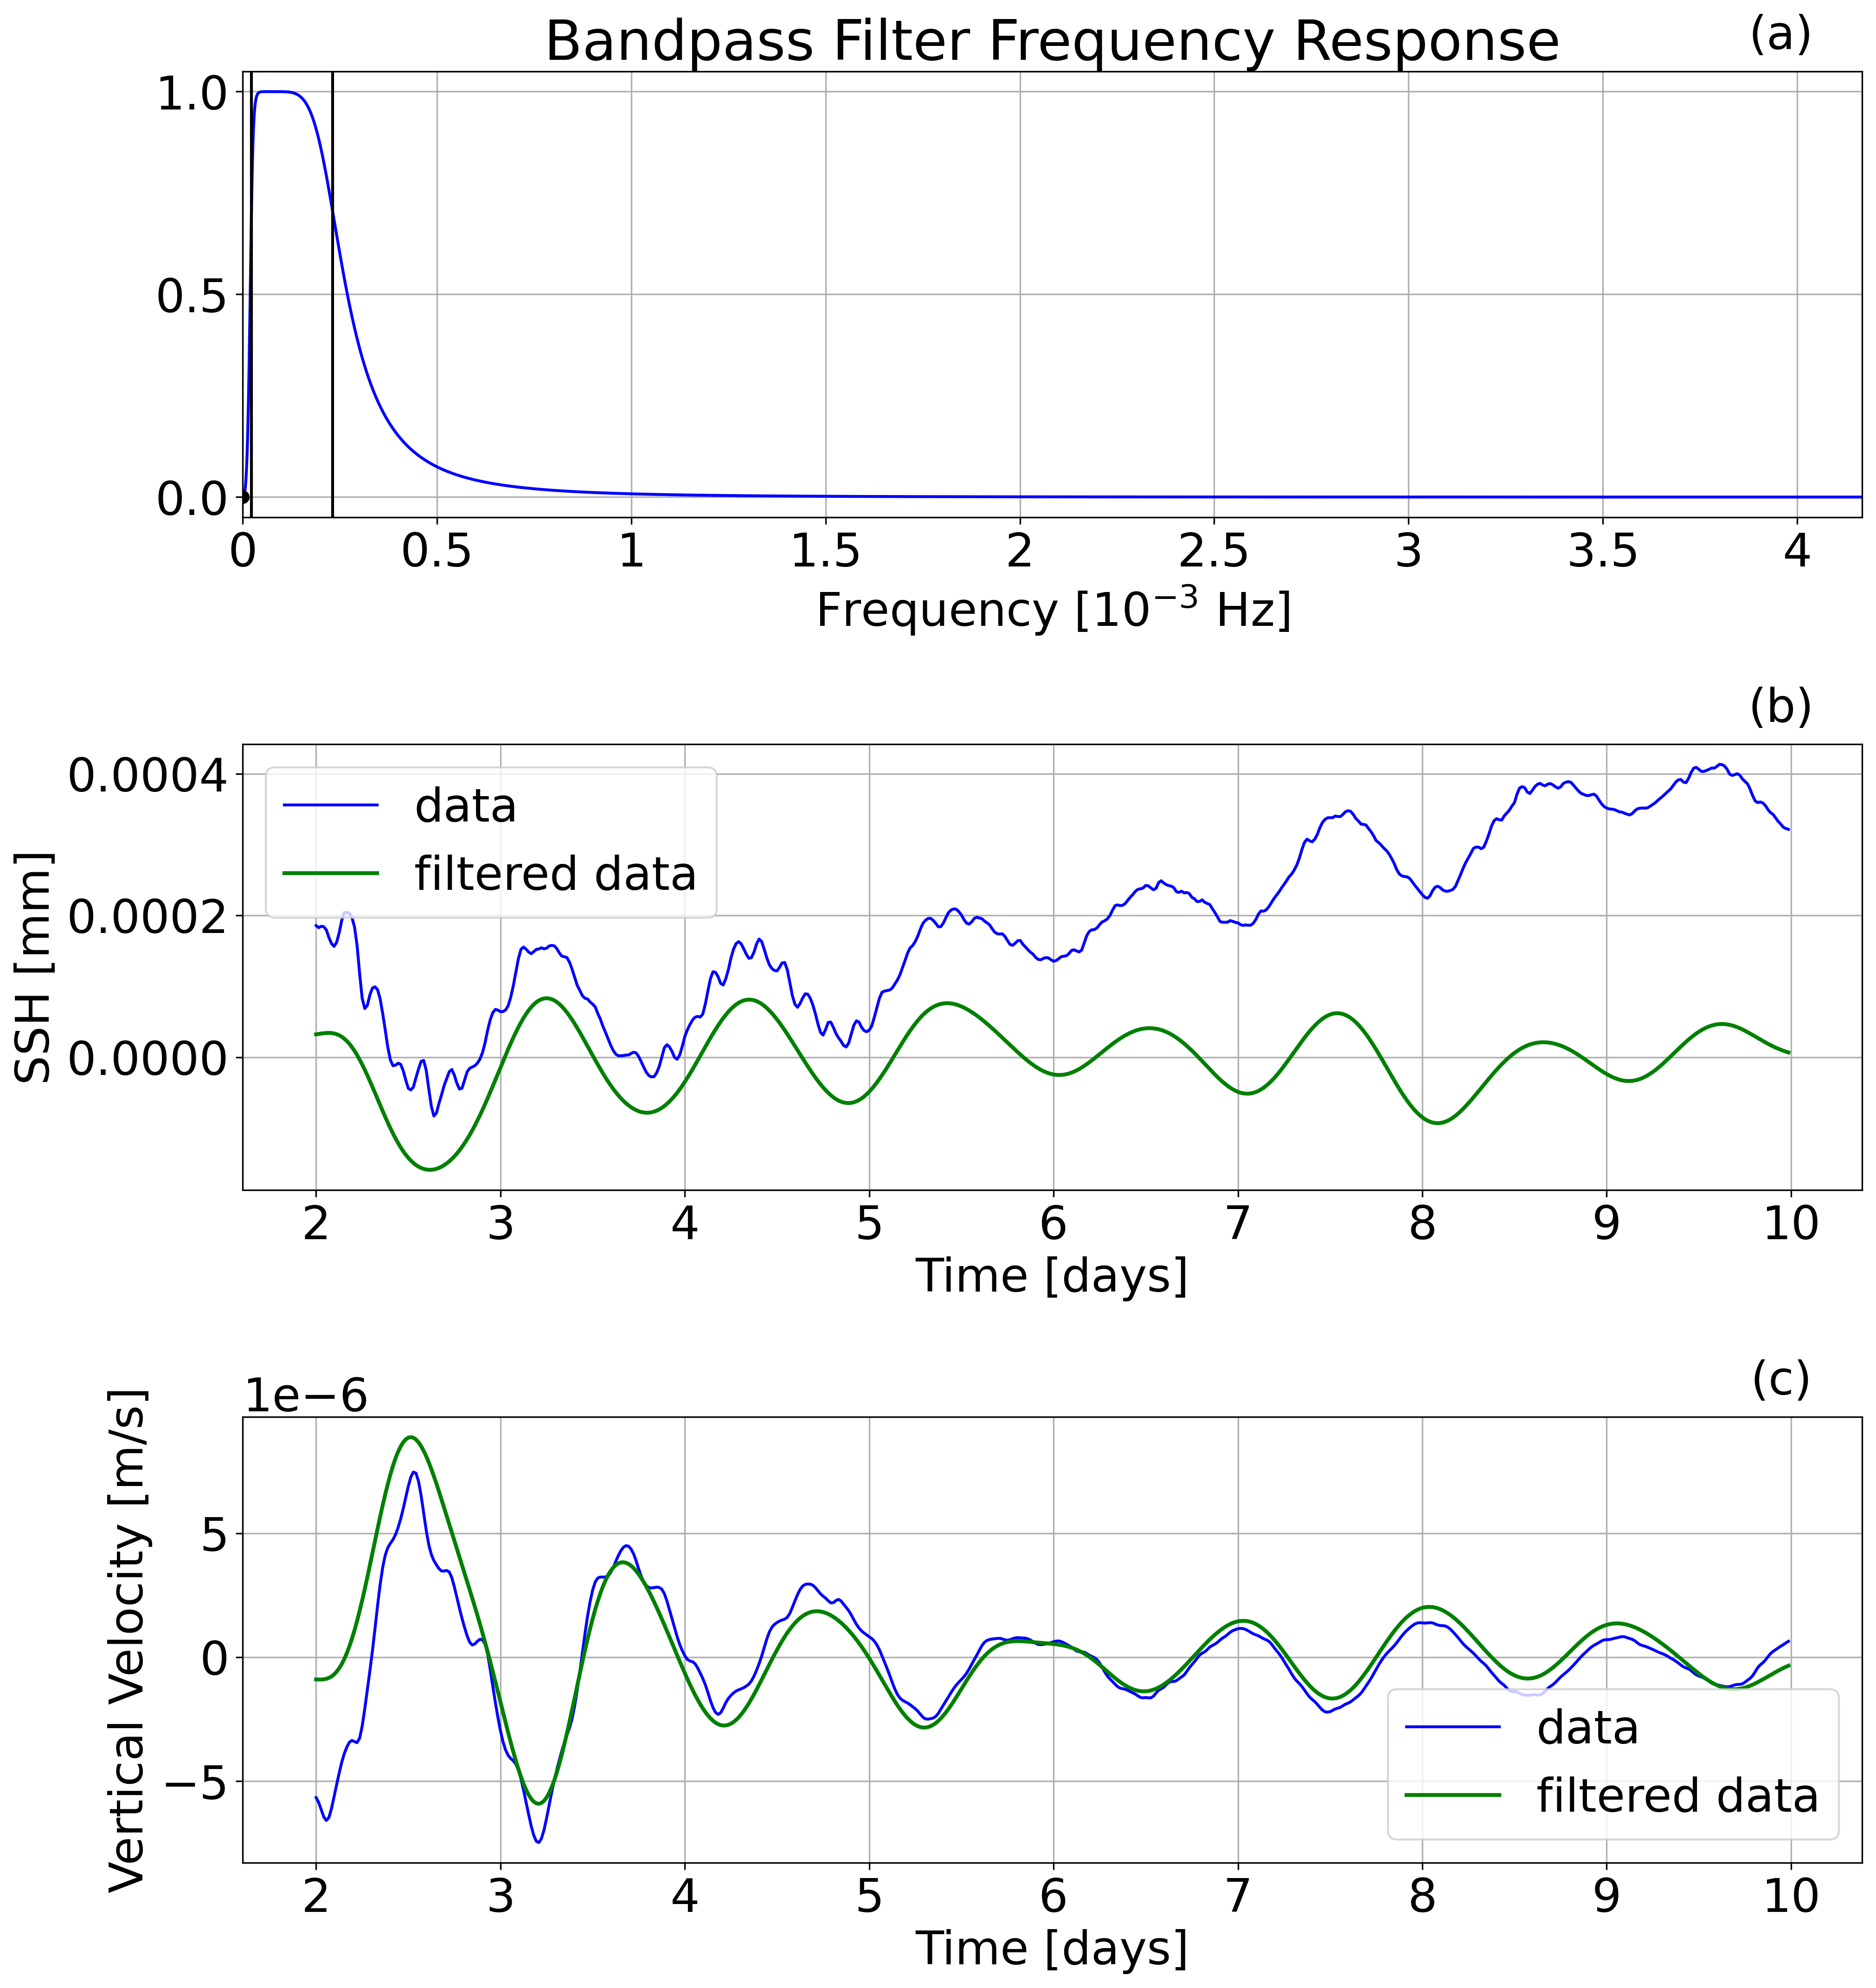

In [91]:
# Setting standard filter requirements.
order = 3
fs = 1/1200       
cutoff =np.array([1/432000, 1/43200])

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = sig.freqz(b, a, worN=8000)
ax0=plt.subplot(3, 1, 1)
ax0.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax0.plot(cutoff, 'ko')
ax0.axvline(cutoff[0], color='k')
ax0.axvline(cutoff[1], color='k')
ax0.set_xlim(0, 0.5*fs)
ax0.set_title("Bandpass Filter Frequency Response")
ax0.set_xlabel('Frequency [$10^{-3}$ Hz]')
ax0.grid()
ax0.text(0.95,1.05,'(a)',horizontalalignment='center',transform=ax0.transAxes)

ax0.set_xticks([0, 0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004])
ax0.set_xticklabels(['0', '0.5', '1', '1.5','2', '2.5', '3', '3.5', '4'])

# Creating the data for filteration
t=TIME*60
d=42
data = etadif[:,d*1]

eta=dsw.ETA[:,d*1].values-dsn.ETA[:,d*1].values

# Filtering and plotting
y = butter_lowpass_filter(data, cutoff, fs, order)

ax=plt.subplot(3, 1, 2)
ax.plot(t/(60*60*24), eta, 'b-', label='data')
ax.plot(t/(60*60*24), y, 'g-', linewidth=2, label='filtered data')
ax.set_xlabel('Time [days]')
ax.set_ylabel("SSH [mm]")
ax.text(0.95,1.05,'(b)',horizontalalignment='center',transform=ax.transAxes)
ax.grid()
ax.legend()

plt.tight_layout()

W=Ww[:,d*1]-Wn[:,d*1]
dataw = VELdif[:,d*1]

ax2=plt.subplot(3, 1, 3)
yw = butter_lowpass_filter(dataw, cutoff, fs, order)

ax2.plot(t/(60*60*24), W, 'b-', label='data')
ax2.plot(t/(60*60*24), yw, 'g-', linewidth=2, label='filtered data')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel("Vertical Velocity [m/s]")
ax2.text(0.95,1.05,'(c)',horizontalalignment='center',transform=ax2.transAxes)
ax2.grid()
ax2.legend(loc='lower right')

#plt.tight_layout()
#ax.subplots_adjust(hspace=0.35)
#ax.show()